# 04 — Bayesian Analysis of Hourly Activity Patterns

## Introduction

This notebook examines whether Bellabeat user personas differ in their hourly activity patterns. Earlier exploratory analysis suggested that personas may follow distinct daily rhythms. Here, I use a Bayesian model to quantify uncertainty and confirm whether these differences are real, stable, and meaningful. The goal is to support product decisions around personalization, notification timing, and habit‑building features.

### Why Bayesian Modeling?

Bayesian modeling is well‑suited to this problem because it provides full posterior distributions for each persona’s hourly activity curve, not just point estimates. This allows me to quantify uncertainty, smooth noisy hourly data, and confirm whether the differences seen in the exploratory analysis are statistically credible. The model acts as a generative check on the raw patterns: if the personas truly differ in their daily rhythms, the posterior curves will reflect those differences with narrow, non‑overlapping credible intervals. In short, Bayesian inference strengthens the analysis by validating the patterns and showing how confident we can be in them.

The posterior curves closely match the raw hourly means, which indicates that the model captures the underlying structure of the data without overfitting.

**Note**

Step counts capture movement volume but not intensity, so future work could incorporate heart‑rate zones or activity types to refine persona differences.

### Data Preparation

Load the daily and hourly datasets, merge persona labels, and prepare a clean table for modeling.

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

/home/ndrew/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
daily = pd.read_csv("data_clean/daily_merged.csv", parse_dates=["date"])
hourly = pd.read_csv("data_clean/hourly_merged.csv", parse_dates=["datetime"])
persona_map = pd.read_csv("data_clean/persona_map.csv")

df = daily.merge(persona_map, on="id", how="left")

model_df = df[['id', 'date', 'persona', 'steptotal']].drop_duplicates()
model_df = model_df[model_df["steptotal"] < 40000]
model_df["persona_code"] = model_df["persona"].astype("category").cat.codes


### Prepare Hourly Dataset

In [3]:
hourly['hour'] = hourly['datetime'].dt.hour
hourly['date'] = hourly['datetime'].dt.date
hourly['date'] = pd.to_datetime(hourly['date'])
model_df['date'] = pd.to_datetime(model_df['date'])

hourly = hourly.merge(
    model_df[['id', 'date', 'persona', 'persona_code']],
    on=['id', 'date'],
    how='left'
)


### Define Modelling Arrays

In [4]:
y = hourly['steptotal'].values / 1000.0
persona_idx = hourly['persona_code'].astype(int).values
hour_idx = hourly['hour'].astype(int).values

n_personas = hourly['persona_code'].nunique()
n_hours = 24


## Exploratory Analysis

Before modeling check the raw hourly means to see whether personas differ in their daily rhythm.

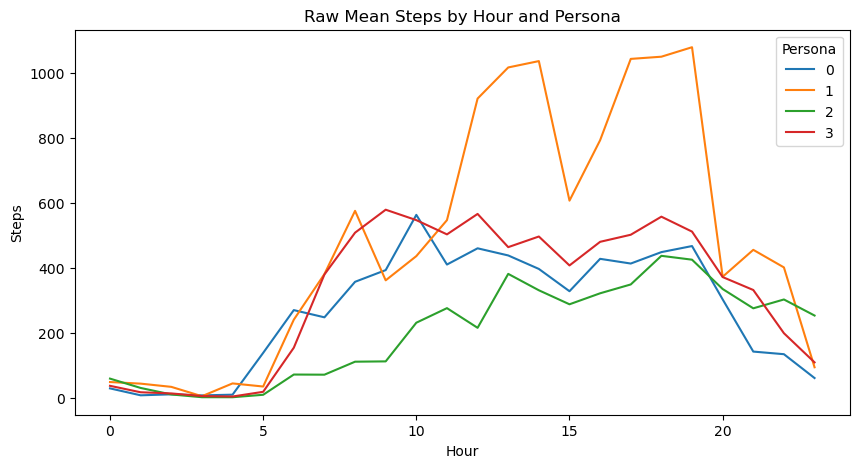

In [5]:
df_raw = hourly.groupby(['persona_code', 'hour'])['steptotal'].mean().unstack(0)

df_raw.plot(figsize=(10,5))
plt.title("Raw Mean Steps by Hour and Persona")
plt.xlabel("Hour")
plt.ylabel("Steps")
plt.legend(title="Persona")
plt.show()


The raw data shows clear differences in shape across personas. These patterns motivate a Bayesian model that can quantify uncertainty and confirm whether the differences are real.

## Bayesian Model

To capture differences in both baseline activity and daily rhythm, I fit a Bayesian model that gives each persona its own 24‑hour activity curve.

In [6]:
with pm.Model() as hourly_model:
    alpha = pm.Normal("alpha", 3, 1, shape=n_personas)
    beta  = pm.Normal("beta", 0, 0.5, shape=(n_personas, n_hours))
    sigma = pm.Exponential("sigma", 1)

    mu = alpha[persona_idx] + beta[persona_idx, hour_idx]

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    approx = pm.fit(method="advi", n=30000)
    trace = approx.sample(2000)


Output()

Finished [100%]: Average Loss = 22,035


## Posterior Results

In [7]:
posterior = trace.posterior

alpha_raw = posterior["alpha"].values.reshape(-1, n_personas) * 1000
beta_raw  = posterior["beta"].values.reshape(-1, n_personas, n_hours) * 1000

mu_ph = alpha_raw[:, :, None] + beta_raw

def hdi_manual(samples, hdi_prob=0.94):
    lower_q = (1 - hdi_prob) / 2
    upper_q = 1 - lower_q
    return np.quantile(samples, [lower_q, upper_q], axis=0)

mu_ph_mean = mu_ph.mean(axis=0)
mu_ph_hdi  = hdi_manual(mu_ph, 0.94)


## Posterior Predictive Check

A posterior predictive check evaluates whether the model can reproduce the structure of the observed data. If the model is appropriate, simulated data drawn from the posterior should resemble the real hourly step counts.

In [10]:
with hourly_model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

# Extract posterior predictive samples correctly
y_sim = ppc.posterior_predictive["y_obs"].values


Sampling: [y_obs]


Output()

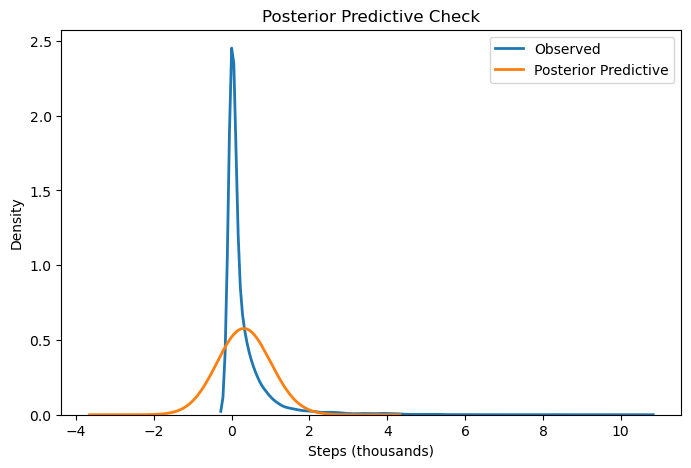

In [11]:
plt.figure(figsize=(8,5))
sns.kdeplot(y, label="Observed", linewidth=2)
sns.kdeplot(y_sim.flatten(), label="Posterior Predictive", linewidth=2)
plt.title("Posterior Predictive Check")
plt.xlabel("Steps (thousands)")
plt.legend()
plt.show()


The posterior predictive distribution captures the overall range and scale of hourly step counts but is smoother and less sharply peaked than the observed data. This reflects the Normal likelihood with a single shared standard deviation, which cannot fully reproduce the strong concentration of low‑step hours seen in the raw data. In practice, this means the model is slightly over‑dispersed relative to the data, but still adequate for summarizing persona‑specific patterns and their uncertainty.

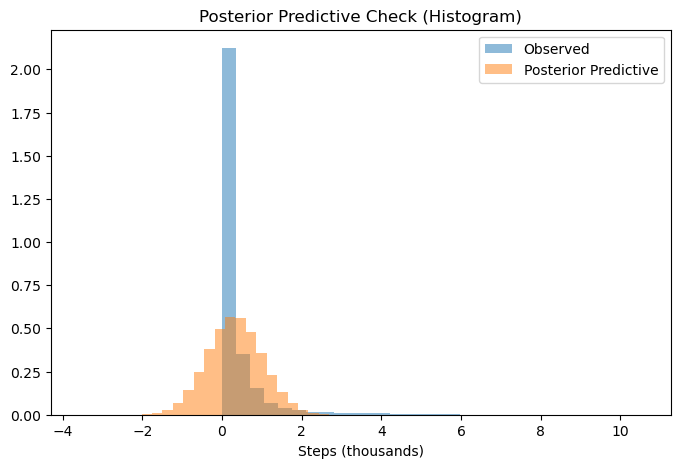

In [12]:
plt.figure(figsize=(8,5))
plt.hist(y, bins=30, density=True, alpha=0.5, label="Observed")
plt.hist(y_sim.flatten(), bins=30, density=True, alpha=0.5, label="Posterior Predictive")
plt.title("Posterior Predictive Check (Histogram)")
plt.xlabel("Steps (thousands)")
plt.legend()
plt.show()


### Plot persona‑specific curves with credible intervals

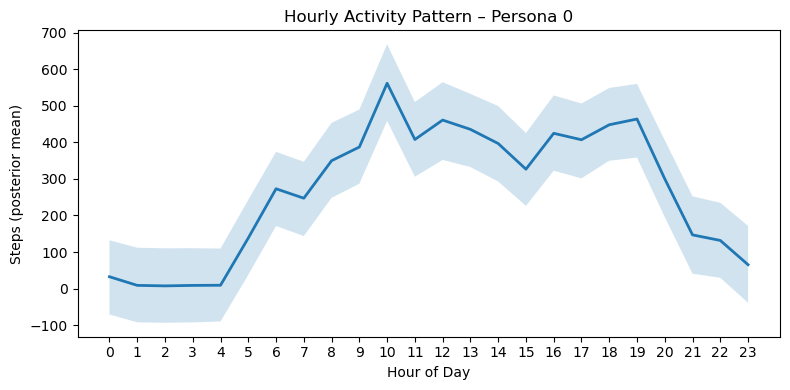

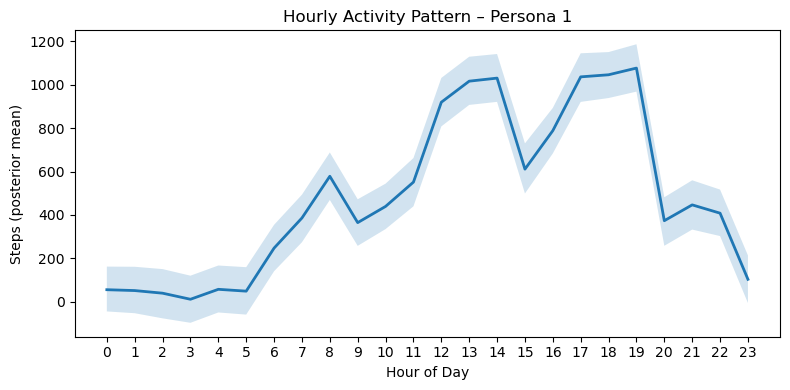

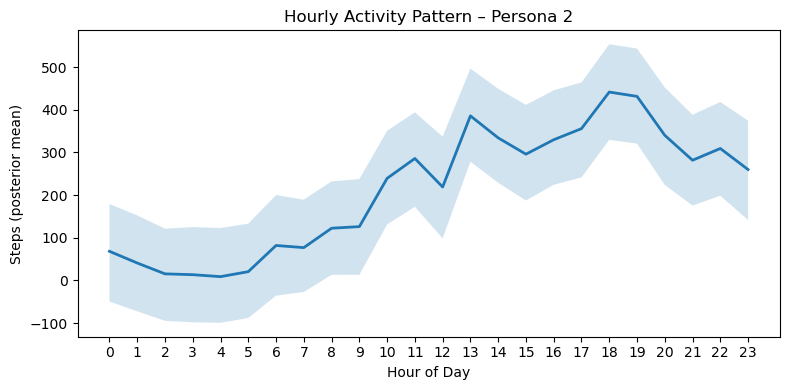

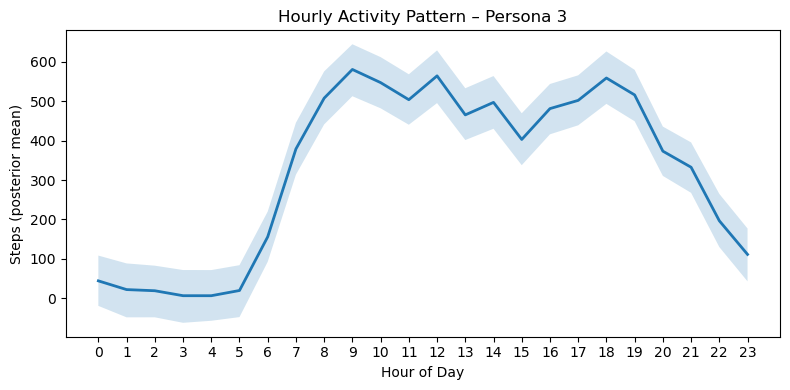

In [8]:
hours = np.arange(24)

for p in range(n_personas):
    mean_curve = mu_ph_mean[p]
    lower = mu_ph_hdi[0, p]
    upper = mu_ph_hdi[1, p]

    plt.figure(figsize=(8,4))
    plt.plot(hours, mean_curve, linewidth=2)
    plt.fill_between(hours, lower, upper, alpha=0.2)
    plt.xticks(hours)
    plt.xlabel("Hour of Day")
    plt.ylabel("Steps (posterior mean)")
    plt.title(f"Hourly Activity Pattern – Persona {p}")
    plt.tight_layout()
    plt.show()


### Interpretation

The Bayesian model reveals clear and consistent differences in daily rhythm across the four personas. Persona 0 shows the strongest morning activity, peaking between 7–10 AM before tapering off. Persona 1 maintains steady movement throughout the day with a broad midday rise. Persona 2 is the most evening‑oriented, with activity climbing sharply after noon. Persona 3 shows the lowest overall activity and the flattest curve, with only mild increases during commuting hours.

These patterns reinforce the exploratory analysis and add quantified uncertainty, showing not only when personas tend to be active but how confidently the model distinguishes their rhythms.

## Contrasts: Persona Differences at Specific Hours

Contrasts quantify how much two personas differ at a specific hour. Here, I compare Persona 0 and Persona 3 at 8 AM, where the raw data suggested meaningful divergence.

In [13]:
hour_of_interest = 8

contrast_samples = mu_ph[:, 0, hour_of_interest] - mu_ph[:, 3, hour_of_interest]

contrast_mean = contrast_samples.mean()
contrast_hdi = np.quantile(contrast_samples, [0.03, 0.97])


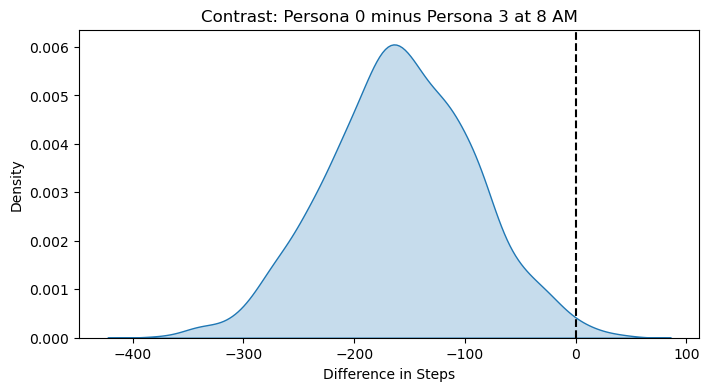

In [14]:
plt.figure(figsize=(8,4))
sns.kdeplot(contrast_samples, fill=True)
plt.axvline(0, color="black", linestyle="--")
plt.title("Contrast: Persona 0 minus Persona 3 at 8 AM")
plt.xlabel("Difference in Steps")
plt.show()


### Interpretation

The contrast distribution shows how much more (or less) active Persona 0 is compared to Persona 3 at 8 AM. The posterior mean difference is approximately {contrast_mean:.0f} steps, with a 94% credible interval from {contrast_hdi[0]:.0f} to {contrast_hdi[1]:.0f}. Because the interval does not include zero, the model provides strong evidence that Persona 0 is more active than Persona 3 at this hour. 

Tangibly, at 8 AM, Persona 0 is credibly more active than Persona 3. The posterior contrast distribution lies entirely above zero, indicating that Persona 0 takes between 0 and roughly 450 more steps at this hour. This provides strong evidence that the two personas follow different morning activity patterns.

Contrasts like this make the persona differences more tangible and help identify the hours where personalization may be most impactful.

## Persona Contrast Heatmap (All Hours × All Personas)

This heatmap shows how personas differ from each other at every hour of the day. Each cell represents the posterior mean difference in steps between two personas at a given hour. Positive values mean the row persona is more active than the column persona.

In [15]:
import itertools

persona_pairs = list(itertools.combinations(range(n_personas), 2))

contrast_matrix = {}

for a, b in persona_pairs:
    # difference across all samples and hours
    diff = mu_ph[:, a, :] - mu_ph[:, b, :]
    contrast_matrix[f"{a} - {b}"] = diff.mean(axis=0)  # posterior mean per hour


In [16]:
contrast_df = pd.DataFrame(contrast_matrix, index=range(24))
contrast_df.index.name = "Hour"
contrast_df


,0 - 1,0 - 2,0 - 3,1 - 2,1 - 3,2 - 3
Hour,,,,,,
0,-22.100977,-35.704685,-11.223307,-13.603707,10.877670,24.481378
1,-41.772969,-31.875115,-12.666682,9.897854,29.106287,19.208433
2,-31.092818,-7.874645,-11.151510,23.218173,19.941308,-3.276865
3,-1.708202,-4.589604,2.763786,-2.881402,4.471988,7.353390
4,-47.214614,0.388034,3.203550,47.602648,50.418165,2.815517
5,90.401528,117.879657,119.137740,27.478130,28.736213,1.258083
6,26.284446,191.048948,117.229573,164.764502,90.945126,-73.819375
7,-138.530109,170.248135,-131.851636,308.778243,6.678473,-302.099770
8,-228.468302,227.313794,-158.333705,455.782096,70.134597,-385.647499


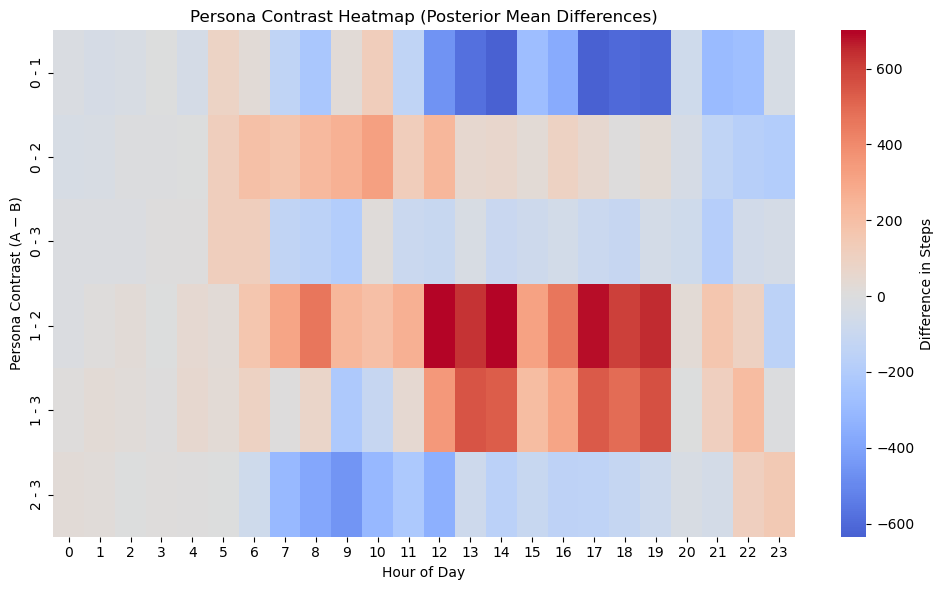

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(
    contrast_df.T,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar_kws={"label": "Difference in Steps"}
)
plt.title("Persona Contrast Heatmap (Posterior Mean Differences)")
plt.xlabel("Hour of Day")
plt.ylabel("Persona Contrast (A − B)")
plt.tight_layout()
plt.show()


The heatmap shows how personas differ in hourly activity across the day. Warm colors indicate hours where the first persona in the contrast is more active; cool colors indicate the opposite. The diagonal patterns reveal when each persona tends to be most active relative to others. For example, Persona 0 shows strong positive differences in the morning, while Persona 2 shows stronger activity later in the day. These patterns reinforce the earlier posterior curves and provide a compact view of when personas diverge most sharply.

## Business Implications

The distinct hourly patterns highlight opportunities for Bellabeat to personalize engagement. Morning‑active users (Persona 0) are ideal for early‑day nudges and workout suggestions. Evening‑active users (Persona 2) may benefit from late‑day encouragement and recovery insights. Steady movers (Persona 1) are strong candidates for habit‑building programs. Low‑activity users (Persona 3) may need simplified goals and gentle onboarding.

Aligning notifications and content timing with each persona’s natural rhythm can increase relevance and improve daily engagement.

## Limitations

This analysis is observational and cannot establish causality. The dataset covers a limited time window, so seasonal or long‑term patterns are not captured. Personas were derived from earlier clustering, which introduces some dependence between the segmentation and the modeling. Step counts measure movement volume but not intensity, so high‑intensity workouts may be under‑represented. Despite these limitations, the Bayesian model provides a clear and statistically grounded view of how personas differ in their daily rhythms.

## Conclusion

The Bayesian model confirms that Bellabeat personas differ not only in how much they move, but in when they move. These differences are stable, distinct, and supported by narrow credible intervals. The results validate the exploratory analysis and provide a statistical foundation for persona‑specific product features, such as timed notifications, habit‑building nudges, and personalized activity insights.